In [66]:
# TODO: Fix the Overfitting of the Model to the Training Data, Make a Better Model

In [67]:
import glob
import os
import os.path
from pathlib import Path
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from timeit import default_timer as timer

import torch
from torch import nn
import torchvision
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [68]:
# Device Agnostic Code
device = "cuda" if torch.cuda.is_available() else "cpu"

In [69]:
# Image Path
data_path = Path("/content/drive/MyDrive/")
image_path = data_path / "brain-tumor-mri"
for dirpath, dirnames, filenames in os.walk(image_path):
  print(f"There are {len(dirnames)} directories and {len(filenames)} image in {dirpath}.")

There are 3 directories and 0 image in /content/drive/MyDrive/brain-tumor-mri.
There are 4 directories and 0 image in /content/drive/MyDrive/brain-tumor-mri/Training.
There are 0 directories and 827 image in /content/drive/MyDrive/brain-tumor-mri/Training/pituitary_tumor.
There are 0 directories and 822 image in /content/drive/MyDrive/brain-tumor-mri/Training/meningioma_tumor.
There are 0 directories and 826 image in /content/drive/MyDrive/brain-tumor-mri/Training/glioma_tumor.
There are 0 directories and 395 image in /content/drive/MyDrive/brain-tumor-mri/Training/no_tumor.
There are 0 directories and 0 image in /content/drive/MyDrive/brain-tumor-mri/.ipynb_checkpoints.
There are 4 directories and 0 image in /content/drive/MyDrive/brain-tumor-mri/Testing.
There are 0 directories and 74 image in /content/drive/MyDrive/brain-tumor-mri/Testing/pituitary_tumor.
There are 0 directories and 115 image in /content/drive/MyDrive/brain-tumor-mri/Testing/meningioma_tumor.
There are 0 directories

In [70]:
# Setup train and test paths
train_dir = image_path / "Training"
test_dir = image_path / "Testing"  

### Visualizing some of the files

Random Image Path: /content/drive/MyDrive/brain-tumor-mri/Training/no_tumor/image(173).jpg
Image Class: no_tumor
Image Height: 512
Image Width: 416


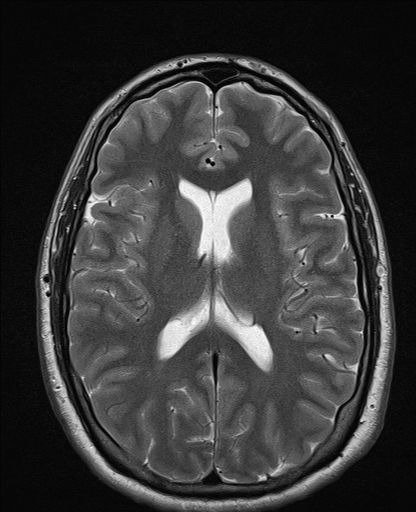

In [71]:
import random
from PIL import Image

# Set the seed
random.seed(42)

image_path_list = list(image_path.glob("*/*/*.jpg"))
random_image_path = random.choice(image_path_list)
image_class = random_image_path.parent.stem
img = Image.open(random_image_path)

print(f"Random Image Path: {random_image_path}")
print(f"Image Class: {image_class}")
print(f"Image Height: {img.height}")
print(f"Image Width: {img.width}")
img

### Transforming the Data

In [72]:
data_transform = transforms.Compose([
    transforms.Resize(size = (224,224)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ToTensor()
])

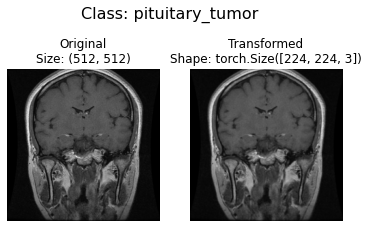

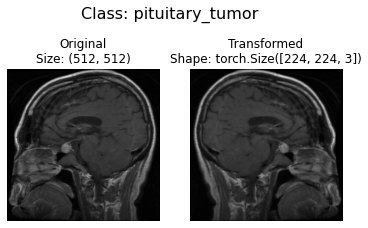

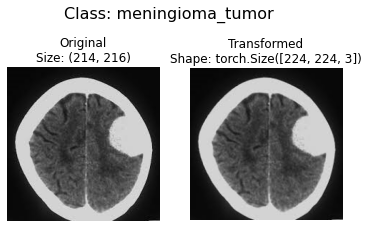

In [73]:
def plot_transformed_images(image_paths, transform, n = 3, seed = None):
  """Selects random images from a path of images and load/transforms them then 
  plots the original vs the transformed verions"""
  if seed:
    random.seed(seed)
  random_image_paths = random.sample(image_paths, k=n)
  for image_path in random_image_paths:
    with Image.open(image_path) as f:
      fig, ax = plt.subplots(nrows=1,ncols=2)
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # Transform and plot target image
      transformed_image = transform(f).permute(1,2,0)
      ax[1].imshow(transformed_image)
      ax[1].set_title(f"Transformed\nShape: {transformed_image.shape}")  
      ax[1].axis("off")

      fig.suptitle(f"Class: {image_path.parent.stem}", fontsize = 16)
plot_transformed_images(image_paths = image_path_list,
                        transform=data_transform,
                        n = 3,
                        seed = None)

### Loading the Image using ImageFolder

In [74]:
train_data = datasets.ImageFolder(root=train_dir,
                                  transform=data_transform, # Transform for the data
                                  target_transform=None)  # Transform for the target/label

test_data = datasets.ImageFolder(root=test_dir,
                                 transform = data_transform)

train_data, test_data

(Dataset ImageFolder
     Number of datapoints: 2870
     Root location: /content/drive/MyDrive/brain-tumor-mri/Training
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ), Dataset ImageFolder
     Number of datapoints: 394
     Root location: /content/drive/MyDrive/brain-tumor-mri/Testing
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
            ))

### Prepare DataLoader

In [75]:
BATCH_SIZE = 32

train_dataloader = DataLoader(dataset = train_data,
                              batch_size = BATCH_SIZE,
                              shuffle = True)

test_dataloader = DataLoader(dataset = test_data,
                             batch_size = BATCH_SIZE)

In [76]:
# Look at the number of batches
print(f"DataLoaders: {train_dataloader, test_dataloader}")
print(f"Length of train_dataloader: {len(train_dataloader)} batches of {BATCH_SIZE}")
print(f"Length of test_dataloader: {len(test_dataloader)} batches of {BATCH_SIZE}")

DataLoaders: (<torch.utils.data.dataloader.DataLoader object at 0x7ff66c96bd00>, <torch.utils.data.dataloader.DataLoader object at 0x7ff66c96b850>)
Length of train_dataloader: 90 batches of 32
Length of test_dataloader: 13 batches of 32


In [77]:
# Check out what is inside the training dataloader
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 3, 224, 224]), torch.Size([32]))

### Creating a Baseline CNN

In [78]:
# Create Model Framework
class BrainTumorModelV0(nn.Module):
  def __init__(self, input_shape, hidden_units, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = hidden_units),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Dropout(p = 0.1),
        nn.Conv2d(in_channels = hidden_units,
                  out_channels = hidden_units,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = hidden_units),
        nn.MaxPool2d(kernel_size = 2)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features = hidden_units*56*56,
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    return x

In [79]:
# Initialize Model
torch.manual_seed(42)
model_0 = BrainTumorModelV0(3,10, 4).to(device)

In [80]:
# Sanity Check the model on random data
toy_model = BrainTumorModelV0(3, 10, 4)
random_data = torch.randn(size = (3, 224, 224))
toy_model(random_data.unsqueeze(0))

tensor([[-0.2705,  0.5048, -1.1869, -0.3356]], grad_fn=<AddmmBackward0>)

### Loss Function and Optimizer

In [81]:
# Loss Function
loss_fn = nn.CrossEntropyLoss().to(device)

# Optimizer
optimizer = torch.optim.Adam(params = model_0.parameters(), lr = 0.001)

### Creating the Training and Test Loop Functions

In [82]:
!pip install torchmetrics
from torchmetrics import Accuracy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [83]:
# Accuracy Function
accuracy = Accuracy(task="multiclass", num_classes = 4).to(device)

In [84]:
def train_step(model: nn.Module,
               data_loader : torch.utils.data.DataLoader,
               loss_fn : nn.Module,
               optimizer : torch.optim,
               accuracy,
               device : torch.device = device):

  model.train()
  train_loss, train_acc = 0, 0
  for batch, (X,y) in enumerate(data_loader):
    X, y = X.to(device), y.to(device)

    # Forward Pass
    y_pred = model(X)

    # Calculate the loss and accuracy
    loss = loss_fn(y_pred, y)
    train_loss += loss
    acc = accuracy(y_pred.argmax(dim = 1), y)
    train_acc += acc

    # Optimizer zero grad
    optimizer.zero_grad()

    # Backpropagation
    loss.backward()

    # Optimizer
    optimizer.step()

    # Print
    if batch % 15 == 0:
        print(f"Looked at {batch * len(X)}/{len(data_loader.dataset)} samples")

  # Divide total train loss by length of train dataloader
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)
  print(f"Train loss: {train_loss:.5f} | Train Acc: {train_acc:.2f}")

In [85]:
def test_step(model : nn.Module,
              data_loader : torch.utils.data.DataLoader,
              loss_fn : nn.Module,
              accuracy,
              device : torch.device = device):
  model.eval()
  test_loss, test_acc = 0, 0
  with torch.inference_mode():
    for X, y in data_loader:
      X, y = X.to(device), y.to(device)

      # Forward Step
      y_pred = model(X)

      # Calculate loss and accuracy
      y_loss = loss_fn(y_pred, y)
      test_loss += y_loss
      acc = accuracy(y_pred.argmax(dim = 1), y)
      test_acc += acc
    
    # Take the average loss and accuracy
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

  # Print
  print(f"Test Loss: {test_loss:.5f} | Test acc: {test_acc:.2f}\n")

### Training the Baseline Model

In [86]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure start time
start_time = timer()

# Epochs
epochs = 5

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model = model_0,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy = accuracy,
             device = device)
  test_step(model = model_0,
             data_loader = test_dataloader,
             loss_fn = loss_fn,
             accuracy = accuracy,
             device = device)
  
# End time
end_time = timer()
print(f"Training the model took {end_time - start_time} seconds")

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/2870 samples
Looked at 480/2870 samples
Looked at 960/2870 samples
Looked at 1440/2870 samples
Looked at 1920/2870 samples
Looked at 2400/2870 samples
Train loss: 2.42255 | Train Acc: 0.64
Test Loss: 6.08348 | Test acc: 0.47

Epoch: 1
-------
Looked at 0/2870 samples
Looked at 480/2870 samples
Looked at 960/2870 samples
Looked at 1440/2870 samples
Looked at 1920/2870 samples
Looked at 2400/2870 samples
Train loss: 1.36450 | Train Acc: 0.77
Test Loss: 5.39708 | Test acc: 0.53

Epoch: 2
-------
Looked at 0/2870 samples
Looked at 480/2870 samples
Looked at 960/2870 samples
Looked at 1440/2870 samples
Looked at 1920/2870 samples
Looked at 2400/2870 samples
Train loss: 0.89212 | Train Acc: 0.82
Test Loss: 6.15072 | Test acc: 0.67

Epoch: 3
-------
Looked at 0/2870 samples
Looked at 480/2870 samples
Looked at 960/2870 samples
Looked at 1440/2870 samples
Looked at 1920/2870 samples
Looked at 2400/2870 samples
Train loss: 0.65330 | Train Acc: 0.86
Test Loss: 5.1863

### Creating a New CNN

In [120]:
# Create Model Framework
class BrainTumorModelV1(nn.Module):
  def __init__(self, input_shape, output_shape):
    super().__init__()
    self.conv_block_1 = nn.Sequential(
        nn.Conv2d(in_channels = input_shape,
                  out_channels = 64,
                  kernel_size= 5,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Conv2d(in_channels = 64,
                  out_channels = 128,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = 128),
        nn.MaxPool2d(kernel_size = 2),
        nn.Dropout(p = 0.25)
    )
    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(in_channels = 128,
                  out_channels = 128,
                  kernel_size= 3,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.Dropout(p = 0.1),
        nn.Conv2d(in_channels = 128,
                  out_channels = 256,
                  kernel_size= 2,
                  stride = 1,
                  padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(num_features = 256),
        nn.MaxPool2d(kernel_size = 2),
        nn.Dropout(p = 0.33)
    )
    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Dropout(p = 0.5),
        nn.Linear(in_features = 256*56*56,
                  out_features = output_shape)
    )

  def forward(self, x):
    x = self.conv_block_1(x)
    # print(f"Output shape of conv_block_1: {x.shape}")
    x = self.conv_block_2(x)
    # print(f"Output shape of conv_block_2: {x.shape}")
    x = self.classifier(x)
    # print(f"Output shape of classifier: {x.shape}")
    return x

In [121]:
# Sanity Check the model on random data
toy_model = BrainTumorModelV1(3, 4)
random_data = torch.randn(size = (3, 224, 224))
toy_model(random_data.unsqueeze(0))

tensor([[ 2.0396,  0.8756, -0.7814,  1.4649]], grad_fn=<AddmmBackward0>)

In [122]:
model_1 = BrainTumorModelV1(3, 4).to(device)

In [123]:
# Loss Function
loss_fn = nn.CrossEntropyLoss().to(device)

# Optimizer
optimizer = torch.optim.Adam(params = model_1.parameters(), lr = 0.001)

In [ ]:
torch.manual_seed(42)
torch.cuda.manual_seed(42)

# Measure start time
start_time_1 = timer()

# Epochs
epochs = 15

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n-------")
  train_step(model = model_1,
             data_loader = train_dataloader,
             loss_fn = loss_fn,
             optimizer = optimizer,
             accuracy = accuracy,
             device = device)
  test_step(model = model_1,
             data_loader = test_dataloader,
             loss_fn = loss_fn,
             accuracy = accuracy,
             device = device)
  
# End time
end_time_1 = timer()
print(f"Training the model took {end_time_1 - start_time_1} seconds")

  0%|          | 0/15 [00:00<?, ?it/s]

Epoch: 0
-------
Looked at 0/2870 samples
Looked at 480/2870 samples
Looked at 960/2870 samples
Looked at 1440/2870 samples
Looked at 1920/2870 samples
Looked at 2400/2870 samples
Train loss: 42.71237 | Train Acc: 0.60
Test Loss: 259.20532 | Test acc: 0.38

Epoch: 1
-------
Looked at 0/2870 samples
Looked at 480/2870 samples
Looked at 960/2870 samples
Looked at 1440/2870 samples
Looked at 1920/2870 samples
Looked at 2400/2870 samples
Train loss: 33.43252 | Train Acc: 0.71
Test Loss: 288.41006 | Test acc: 0.44

Epoch: 2
-------
Looked at 0/2870 samples
Looked at 480/2870 samples
Looked at 960/2870 samples
Looked at 1440/2870 samples
Looked at 1920/2870 samples
Looked at 2400/2870 samples
Train loss: 26.17161 | Train Acc: 0.77
Test Loss: 269.99982 | Test acc: 0.47

Epoch: 3
-------
Looked at 0/2870 samples
Looked at 480/2870 samples
Looked at 960/2870 samples
Looked at 1440/2870 samples
Looked at 1920/2870 samples
